# Results & Analysis
After completing the training for the various DQN methods we need to create graphs and analyse the results of the agents.

In [32]:
import sys
sys.path.insert(0, '../../DQN')

from dqn.agent import DQNAgent
from dqn.replay_buffer import ReplayBuffer
from dqn.wrappers import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import ffmpeg
import os
import random
import gym
import torch

In [45]:
env_choices = ["BoxingNoFrameskip-v4", "BreakoutNoFrameskip-v4", "EnduroNoFrameskip-v4"]
choice_num = 0
env_name = env_choices[choice_num]

In [46]:
results = pd.read_csv("../../DQN/results/boxing_2/rewards.csv", names=["Rewards"])
results['Episode'] = results.index
results.head()

,Rewards,Episode
0,7.0,0
1,-4.0,1
2,1.0,2
3,2.0,3
4,4.0,4


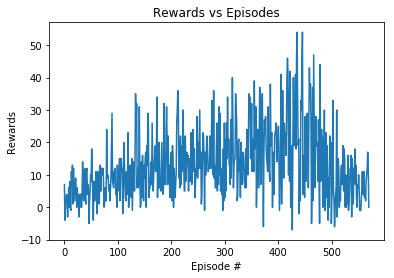

In [47]:
save_loc = "dqn_results_"+env_name
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
plt.plot(results.Episode, results.Rewards)
plt.title("Rewards vs Episodes")
plt.xlabel("Episode #")
plt.ylabel("Rewards")
plt.savefig(os.path.join(save_loc,"rewards_episodes.png"))
plt.show()

In [48]:
def run_agent(env_name, checkpoint_loc, save_directory):
    eps_start= 0.01
    hyper_params = {
        "seed": 42,
        "env": env_name,
        "replay-buffer-size": int(5e3),
        "learning-rate": 1e-4,
        "discount-factor": 0.99,
        "num-steps": int(1e6),
        "batch-size": 32,
        "learning-starts": 10000,
        "learning-freq": 1,
        "use-double-dqn": True, 
        "target-update-freq": 1000, 
        "eps-start": eps_start, 
        "eps-end": 0.01,
        "eps-fraction": 0.1,
        "print-freq": 10
    }

    np.random.seed(hyper_params["seed"])
    random.seed(hyper_params["seed"])
    env = gym.make(hyper_params["env"])
    env.seed(hyper_params["seed"])

    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    env = WarpFrame(env)
    env = PyTorchFrame(env)
    env = ClipRewardEnv(env)
    env = FrameStack(env, 4)

    replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

    agent = DQNAgent(
        env.observation_space,
        env.action_space,
        replay_buffer,
        use_double_dqn=hyper_params["use-double-dqn"],
        lr=hyper_params['learning-rate'],
        batch_size=hyper_params['batch-size'],
        gamma=hyper_params['discount-factor'],
    )

    agent.policy_network.load_state_dict(torch.load(checkpoint_loc))

    eps_timesteps = hyper_params["eps-fraction"] * \
        float(hyper_params["num-steps"])
    episode_rewards = []
    env = gym.wrappers.Monitor(env, save_directory,force=True)
    state = env.reset()
    done = False
    while not done:
        next_state, _, done, _ = env.step(agent.act(state))
        state = next_state
        env.render()
    env.close()

In [49]:
run_agent(env_name, "../../DQN/results/boxing_2/checkpoint.pth", save_loc)

In [29]:
!ls ../../DQN/results/enduro_1/checkpoint.pth

checkpoint.pth	rewards.csv  videos
